# Laser power increase - beads

In order to download the data, run the [download_data notebook](0_download_data.ipynb) first. 

We immobilized TetraSpeck beads (ThermoFischer) onto a coverslip and placed it on a microscope. We cropped a small region around a single bead and acquired time-series for different values of a laser pulse duration. The time-series were acquired using a [Micro-Manager script](https://github.com/mufpga/analysis/blob/main/acquisition_scripts/beads_pulse_acquisition.bsh).


In [1]:
import os, re
import os.path as op
import numpy as np
import read_roi as rr
import tifffile as tff
from sklearn.linear_model import LinearRegression

# define some matplotlib style for all figures
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [2]:
def read_image(path, norm = False):
    tif = tff.TiffFile(path)
    
    pages = []
    for page in tif.pages:
        array = page.asarray()
        if norm:
            array = array / np.max(array)
            
        pages.append(array)
        
    return np.array(pages)

def read_roi(path):
    return rr.read_roi_file(path)

def extract_roi(roi):
    y0 = roi['bead']['left']
    x0 = roi['bead']['top']
    w = roi['bead']['width']
    h = roi['bead']['height']
    
    return x0, y0, w, h

def average_img(img):
    return np.mean(img, 0)

def average_over_roi(img, roi):
    if roi:
        x0, y0, w, h = extract_roi(roi)
    else:
        x0 = 0
        y0 = 0
        w = img.shape[1]
        h = img.shape[2]
    
    av_img = average_img(img)
    
    return np.mean(av_img[x0:x0+w, y0:y0+h])

def get_roi_mask(img, roi):
    mask = np.ones(img.shape)
    
    if roi:
        x0, y0, w, h = extract_roi(roi)
        mask[x0:x0+w, y0:y0+h] = 0
    
    return mask 

def overlay_roi_im(img, roi, value = 1):
    arr = np.copy(img)
    x0, y0, w, h = extract_roi(roi)
    
    for x in range(w+1):
        arr[x0+x,y0] = value
        arr[x0+x,y0+h] = value
        
    for y in range(h):
        arr[x0,y0+y] = value
        arr[x0+w,y0+y] = value
    
    return arr

def extract_pulse(name):
    rev = name[::-1]
    ind = rev.find('_')
    
    return int(name[len(name)-ind:])

def generate_filename(file):
    rev = file[::-1]
    ind = rev.find(os.sep)
    
    return file[len(file)-ind:]+'_MMStack.ome.tif'

def run_all(root, roi):
    dirs = [x[0] for x in os.walk(root)]
    if root in dirs:
        dirs.remove(root)
        
    pulses = []
    diff_means = []
    inners = []
    outers = []
    stds = []
    for f in dirs:
        pulse = extract_pulse(f)
        file_path = op.join(f, generate_filename(f))
    
        img = read_image(file_path)
        inner = np.mean(average_over_roi(img, roi))
        
        inners.append(inner)
        pulses.append(pulse)
    
    return pulses, inners

def plot_fig(t, v, reg, name, s_x, s_y, file_name = None):
    ax = plt.subplot(111)
    
    ind_min = np.argmin(t)
    ind_max = np.argmax(t)
    yt0 = reg.intercept_+t[ind_min]*reg.coef_[0]
    yt1 = reg.intercept_+t[ind_max]*reg.coef_[0]
    plt.plot([t[ind_min], t[ind_max]], [yt0, yt1], '-', linewidth = 0.7)
    
    plt.plot(t, v, '.')

    #plt.ylim([-0.1, 1])
    #plt.xlim([-0.1, 1])

    plt.title(name)
    plt.xlabel(s_x)
    plt.ylabel(s_y)

    if file_name:
        dir_path = 'figs'
        if not os.path.isdir(dir_path): os.mkdir(dir_path)
        plt.savefig(op.join(dir_path,file_name+'.eps'), format='eps')
        

In [3]:
root = op.join('data','beads','640_5-500')
roi = read_roi(op.join(root,'bead.roi'))

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x201b5e59a00>)

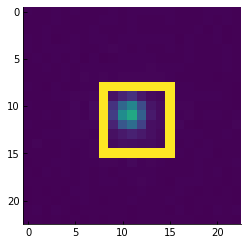

In [4]:
# example showing a single frame with the roi and the outer mask
img = read_image(op.join(root,'Beads_pulse_length_100','Beads_pulse_length_100_MMStack.ome.tif'))
plt.figure(), plt.imshow(overlay_roi_im(average_img(img), roi, 1_000))

Linear fit: y=0.7928435863994558*x+202.52089647495367, R2 = 0.9994466237475355


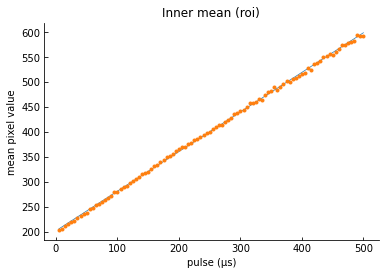

In [5]:
# compute values
pulse_roi, inner_roi = run_all(root, roi)

# linear fit
x = np.array(pulse_roi).reshape(-1, 1)
reg = LinearRegression().fit(x, inner_roi)
print(f'Linear fit: y={reg.coef_[0]}*x+{reg.intercept_}, R2 = {reg.score(x, inner_roi)}')

plot_fig(pulse_roi, inner_roi, reg, 'Inner mean (roi)', 'pulse (\u03bcs)', 'mean pixel value', 'fig_beads_5-500')

dir_path = 'figs'
if not os.path.isdir(dir_path): os.mkdir(dir_path)
plt.savefig(op.join(dir_path,'fig_beads_pulse.eps'), format='eps')